<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning Para Aplicações Biomédicas</font>
## <font color='blue'>Projeto 5 - Parte 2</font>
## <font color='blue'>Machine Learning Para Prever a Resistência a Antibióticos</font>

## Pacotes Python Usados no Projeto

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Imports
import sklearn
import xgboost
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando os Dados Resultantes da Parte 1

In [4]:
# Carrega os dados atribuindo NaN aos valores ausentes (se existirem)
df_dsa = pd.read_csv("dataset_final.csv", na_values = "NaN")

In [5]:
# Shape
df_dsa.shape

(1936, 18304)

In [6]:
# Amostra
df_dsa.head()

,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0


## Seleção dos Dados Usados na Modelagem

In [7]:
# Vamos extrair a lista de medicamentos
lista_medicamentos = df_dsa.iloc[:,1:13].columns

In [8]:
lista_medicamentos

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')

In [9]:
# Define a função que cria um DataFrame específico para um medicamento
def dsa_cria_df(medicamento):
    
    # Cria uma lista de dataframes contendo a coluna "Isolate" e a coluna do medicamento especificado, 
    # e as colunas a partir da 13ª
    df_list = [df_dsa[["Isolate", medicamento]], df_dsa.iloc[:, 13:]]
    
    # Concatena os DataFrames da lista ao longo do eixo das colunas (axis=1)
    df_medicamento = pd.concat(df_list, axis = 1)
    
    # Remove as linhas com valores ausentes (NaN)
    df_medicamento = df_medicamento.dropna()
    
    # Retorna o DataFrame resultante
    return df_medicamento

In [10]:
# Cria o dataframe para um medicamento
AMP_df = dsa_cria_df("AMP")

In [11]:
# Shape
AMP_df.shape

(841, 18293)

In [12]:
# Amostra
AMP_df.head()

,Isolate,AMP,Year_1970.0,Year_1977.0,Year_1994.0,Year_1997.0,Year_1998.0,Year_1999.0,Year_2001.0,Year_2002.0,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,R,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,R,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,R,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


## Função Customizada Para Divisão em Treino e Teste

In [13]:
# Define a função que divide o DataFrame em conjuntos de treino e teste
def dsa_split(df_medicamento, medicamento):
    
    # Inicializa um dicionário para armazenar os conjuntos de treino e teste
    dict_treino_teste = {}
    
    # Extrai as labels (rótulos) do DataFrame, que correspondem ao medicamento especificado
    labels = df_medicamento[medicamento]
    
    # Extrai as features (características), removendo a coluna do medicamento do DataFrame
    features = df_medicamento.drop(columns = [medicamento])
    
    # Divide as features e labels em conjuntos de treino e teste, com 33% dos dados para teste 
    # e uma semente aleatória para reprodutibilidade
    features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                                labels, 
                                                                                test_size = 0.33, 
                                                                                random_state = 42)

    # Armazena as labels de treino no dicionário
    dict_treino_teste['labels_train'] = labels_train
    
    # Armazena as features de treino no dicionário
    dict_treino_teste['features_train'] = features_train
    
    # Armazena as labels de teste no dicionário
    dict_treino_teste['labels_test'] = labels_test
    
    # Armazena as features de teste no dicionário
    dict_treino_teste['features_test'] = features_test

    # Retorna o dicionário contendo os conjuntos de treino e teste
    return dict_treino_teste

In [14]:
# Aplica a função ao dataframe
AMP_dict_treino_teste = dsa_split(AMP_df, "AMP") 

In [15]:
# Visualiza
AMP_dict_treino_teste["features_train"]  

,Isolate,Year_1970.0,Year_1977.0,Year_1994.0,Year_1997.0,Year_1998.0,Year_1999.0,Year_2001.0,Year_2002.0,Year_2003.0,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
755,11658_8#26,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1837,24742_1#282,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1678,18090_8#7,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1520,18090_6#44,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1684,24742_1#103,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,11657_7#7,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
392,11658_4#24,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
761,11658_8#32,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1530,18090_6#54,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print("Medicamento: AMP\n")
for k, df in AMP_dict_treino_teste.items():
    print(k, df.shape)

Medicamento: AMP

labels_train (563,)
features_train (563, 18292)
labels_test (278,)
features_test (278, 18292)


## Estratégia de Engenharia de Atributos - Criando Diferentes Combinações de Atributos

Criaremos a função **dsa_combina_dados**, que nos permitirá escolher quais são as combinações específicas de atributos que queremos usar para treinar nosso modelo. Combinações que serão criadas:

- "G" (prescrição genética)
- "S" (estrutura populacional)
- "GY" (prescrição genética e ano)
- "GS" (prescrição genética e estrutura populacional)

Isso ajuda a reduzir a dimensionalidade dos dados, ao mesmo tempo que mantém informação relevante para treinar o modelo.

In [17]:
# Criamos uma lista de combinações dos atributos que desejamos de testar com nosso modelo
combo_list = ['G', 'S', 'GY', 'GS'] 

In [18]:
# Define a função que combina dados com base em diferentes combinações de atributos
def dsa_combina_dados(features_df, medicamento, combo):

    # Filtra as colunas que começam com "Year"
    year_filter = [col for col in features_df if col.startswith("Year")]
    
    # Seleciona as colunas filtradas relacionadas a anos
    year_feat = features_df[year_filter]

    # Filtra as colunas que começam com "cutoff"
    pop_str_filter = [col for col in features_df if col.startswith("cutoff")]
    
    # Seleciona as colunas filtradas relacionadas à estrutura populacional
    pop_struc_feat = features_df[pop_str_filter]

    # Filtra as colunas que não estão relacionadas à estrutura populacional, não são anos e não são "Isolate"
    gene_presc_filter = [col for col in features_df.columns if col not in pop_str_filter and col not in year_filter and col != "Isolate"]
    
    # Seleciona as colunas filtradas relacionadas à prescrição genética
    gene_presc_feat = features_df[gene_presc_filter]  

    # Se a combinação escolhida for "G" (prescrição genética)
    if combo == 'G':
        
        # Cria uma lista de DataFrames contendo a coluna "Isolate" e as características genéticas
        df_list = [features_df['Isolate'], gene_presc_feat]
        
        # Concatena os DataFrames da lista ao longo do eixo das colunas (axis=1)
        G_feat_df = pd.concat(df_list, axis = 1)
        
        # Remove a coluna "Isolate"
        G_feat_df = G_feat_df.drop(columns = ['Isolate'])
        
        # Retorna o DataFrame resultante
        return G_feat_df

    # Se a combinação escolhida for "S" (estrutura populacional)
    if combo == 'S':
        
        # Cria uma lista de DataFrames contendo a coluna "Isolate" e as características da estrutura populacional
        df_list = [features_df['Isolate'], pop_struc_feat]
        
        # Concatena os DataFrames da lista ao longo do eixo das colunas (axis=1)
        S_feat_df = pd.concat(df_list, axis = 1)
        
        # Remove a coluna "Isolate"
        S_feat_df = S_feat_df.drop(columns = ['Isolate'])
        
        # Retorna o DataFrame resultante
        return S_feat_df

    # Se a combinação escolhida for "GY" (prescrição genética e ano)
    if combo == 'GY':
        
        # Cria uma lista de DataFrames contendo a coluna "Isolate", as características genéticas e os anos
        df_list = [features_df['Isolate'], gene_presc_feat, year_feat]
        
        # Concatena os DataFrames da lista ao longo do eixo das colunas (axis=1)
        GY_feat_df = pd.concat(df_list, axis = 1)
        
        # Remove a coluna "Isolate"
        GY_feat_df = GY_feat_df.drop(columns = ['Isolate'])
        
        # Retorna o DataFrame resultante
        return GY_feat_df

    # Se a combinação escolhida for "GS" (prescrição genética e estrutura populacional)
    if combo == "GS":
        
        # Cria uma lista de DataFrames contendo a coluna "Isolate", as características genéticas 
        # e da estrutura populacional
        df_list = [features_df['Isolate'], gene_presc_feat, pop_struc_feat]
        
        # Concatena os DataFrames da lista ao longo do eixo das colunas (axis=1)
        GS_feat_df = pd.concat(df_list, axis = 1)
        
        # Remove a coluna "Isolate"
        GS_feat_df = GS_feat_df.drop(columns = ['Isolate'])
        
        # Retorna o DataFrame resultante
        return GS_feat_df

In [19]:
# Aplica a função
AMP_GS_train_df = dsa_combina_dados(AMP_dict_treino_teste['features_train'], "AMP", "GS")

In [20]:
# Shape
AMP_GS_train_df.shape

(563, 18269)

In [21]:
# Colunas
AMP_GS_train_df.columns

Index(['yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ', 'tolR',
       'galM',
       ...
       'cutoff_25459', 'cutoff_25654', 'cutoff_25772', 'cutoff_25979',
       'cutoff_26792', 'cutoff_27119', 'cutoff_27236', 'cutoff_27248',
       'cutoff_27690', 'cutoff_45092'],
      dtype='object', length=18269)

## Função Customizada Para Treinamento do Modelo XGBoost

In [22]:
# Define a função que treina um modelo usando os dados de treinamento fornecidos
def dsa_treina_modelo(feat_train_df, lab_train, medicamento, combo):
    
    # Armazena as labels (rótulos) de treinamento
    labels = lab_train
    
    # Inicializa um codificador de labels (LabelEncoder)
    le = preprocessing.LabelEncoder()
    
    # Ajusta o codificador às labels
    le.fit(labels)
    
    # Transforma as labels em uma forma codificada
    labels_t = le.transform(labels)
    
    # Imprime uma mensagem indicando o medicamento e a combinação de treinamento
    print(medicamento + " Combo de Treinamento: " + combo)
    
    # Inicializa um classificador Gradient Boosting com uma semente aleatória para reprodutibilidade
    modelo_dsa = XGBClassifier(random_state = 42)
    
    # Ajusta o modelo aos dados de treinamento
    modelo_dsa = modelo_dsa.fit(feat_train_df, labels_t)
    
    # Retorna o modelo treinado
    return modelo_dsa

In [23]:
# Treina o modelo
AMP_GS_model = dsa_treina_modelo(AMP_GS_train_df, AMP_dict_treino_teste['labels_train'], "AMP", "GS")

AMP Combo de Treinamento: GS


In [24]:
AMP_GS_model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Avaliação do Modelo

In [25]:
# Define a função que faz previsões usando o modelo treinado
def dsa_faz_previsao(combo_Model, features_test):
    
    # Usa o modelo treinado para fazer previsões nas features (características) de teste
    labels_pred = combo_Model.predict(features_test)
    
    # Retorna as labels (rótulos) previstas
    return labels_pred

In [26]:
# Aplica a função
AMP_GS_test_df = dsa_combina_dados(AMP_dict_treino_teste['features_test'], "AMP", "GS")

In [27]:
# Shape
AMP_GS_test_df.shape

(278, 18269)

Usaremos nossa função com o modelo e o conjunto de dados de teste, onde a única combinação com a qual queremos fazer previsões é GS. Também imprimiremos quantos labels nosso modelo previu Resistência(R) e quantos foram previstos como Suscetíveis(S). Neste caso obtivemos 210 previsões de E.Coli Resistentes e 68 previsões de E.Coli Suscetíveis ao medicamento AMP, usando apenas a combinação de características GS.

In [28]:
# Previsão
AMP_GS_labels_pred = dsa_faz_previsao(AMP_GS_model, AMP_GS_test_df)

In [29]:
# Labels previstos
labels_pred = np.where(AMP_GS_labels_pred < 1, "R", "S")

In [30]:
print("Labels Previstos: ", np.unique(labels_pred, return_counts = True))

Labels Previstos:  (array(['R', 'S'], dtype='<U1'), array([210,  68]))


In [31]:
# Define a função que avalia o modelo usando métricas de desempenho e, opcionalmente, exibe a matriz de confusão
def dsa_avalia_modelo(combo_model, 
                      labels_test, 
                      labels_pred, 
                      cf = True):
    
    # Armazena as labels (rótulos) de teste
    labels = labels_test
    
    # Inicializa um codificador de labels (LabelEncoder)
    le = preprocessing.LabelEncoder()
    
    # Ajusta o codificador às labels de teste
    le.fit(labels)
    
    # Transforma as labels de teste em uma forma codificada
    labels_t = le.transform(labels)
    
    # Gera um relatório de classificação e o armazena em um dicionário
    report = classification_report(labels_t, labels_pred, output_dict = True)
    
    # Obtém a acurácia do relatório de classificação
    accuracy = report['accuracy']
    
    # Obtém o recall para a classe "0" (Resistente)
    R_recall = report["0"]['recall']  
    
    # Obtém o recall para a classe "1" (Suscetível)
    S_recall = report["1"]['recall']  
    
    # Se o parâmetro cf (confusion matrix) for True
    if cf:
        
        # Transforma os labels previstos em "R" (Resistente) e "S" (Suscetível)
        labels_pred = np.where(labels_pred < 1, "R", "S")
        
        # Calcula a matriz de confusão usando as labels de teste e previstas
        cm = confusion_matrix(labels_test, labels_pred, labels = np.where(combo_model.classes_ < 1, "R", "S"))
        
        # Cria uma exibição da matriz de confusão
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                      display_labels = np.where(combo_model.classes_ < 1, "R", "S"))
        
        # Plota a matriz de confusão
        disp.plot()
        
        # Exibe a matriz de confusão
        plt.show()
    
    # Retorna a acurácia, o recall para a classe Resistente e o recall para a classe Suscetível
    return [accuracy, R_recall, S_recall]

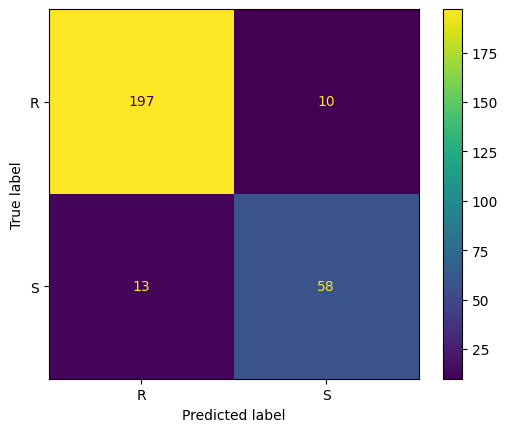

In [32]:
# Avalia o modelo
relatorio = dsa_avalia_modelo(AMP_GS_model, AMP_dict_treino_teste['labels_test'], AMP_GS_labels_pred)

In [33]:
print("Resultados do Modelo Para o Medicamento: AMP")
print("usando Combinação de Atributos: GS")
print("Acurácia: ", relatorio[0])
print("R_recall: ", relatorio[1])
print("S_recall: ", relatorio[2])

Resultados do Modelo Para o Medicamento: AMP
usando Combinação de Atributos: GS
Acurácia:  0.9172661870503597
R_recall:  0.9516908212560387
S_recall:  0.8169014084507042


## Deploy do Modelo e Uso com Novos Dados

In [34]:
# Carrega novos dados 
df_novos_dados = pd.read_csv("novos_dados.csv")

In [35]:
# Previsão
pred_novos_dados = dsa_faz_previsao(AMP_GS_model, df_novos_dados)

In [36]:
# Label previsto
label_previsto = np.where(pred_novos_dados < 1, 
                          "E.Coli Resistente ao Antibiótico AMP", 
                          "E.Coli Suscetível ao Antibiótico AMP")

In [37]:
print(label_previsto)

['E.Coli Resistente ao Antibiótico AMP']


In [38]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [39]:
#%watermark -v -m

In [40]:
#%watermark --iversions

# Fim